**Name:** zhai qiuyu

**EID:** 5999 1830

# CS5489 - Tutorial 3
## Predicting Bike Sharing Usage

In this tutorial you will train a regression function to predict the number people using bike sharing in each day.

First we need to initialize Python.  Run the below cell.

In [3]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import csv
import string
random.seed(100)
import pandas as pd
import xgboost as xgb
from scipy import stats

## Loading Data and Pre-processing
Next we need to load the data.  Download `Bike-Sharing-Dataset.zip`, and **unzip** it in the same directory as this ipynb file.  Then run the following cell to load the data.

In [4]:
# read the data
filename = 'Bike-Sharing-Dataset/day.csv'
df = pd.read_csv(filename)
df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


Here are the columns in the dataset. The last 3 columns are the counts for the day.

In [5]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

Here is a description of the features:
- `instant`: record index
- `dteday`: date
- `season`: season (1: winter, 2:spring, 3:summer, 4:fall)
- `yr`: year (0: 2011, 1:2012)
- `mnth`: month (1=Jan to 12=Dec)
- `holiday`: weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday`: day of the week (1=Sunday to 7=Saturday)
- `workingday`: if day is neither weekend nor holiday is 1, otherwise is 0.
- `weathersit`: weather situation
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- `temp`: Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

The first two columns are the instance number and date, which aren't useful, so we will remove them.

In [6]:
# remove first 2 columns
df.drop(columns=['instant', 'dteday'], inplace=True)

Next we will examine the distribution of the features.

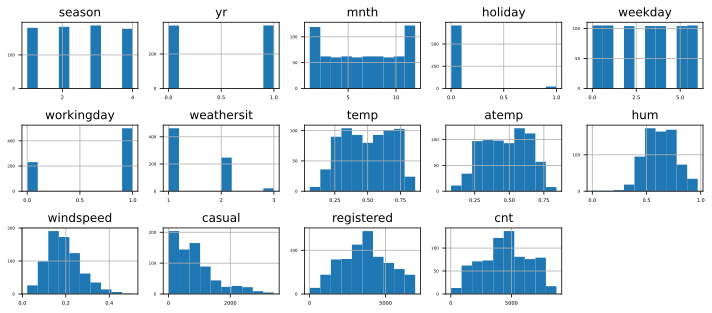

In [7]:
# 展示所有特征的分布（通过直方图可视化）
# df.hist()：pandas的直方图绘制函数，自动为DataFrame中的每一列（数值型特征）绘制直方图
# layout=(14,5)：指定子图布局为14行5列（根据特征数量调整，确保所有子图能放下）
# figsize=(10,20)：设置整个图像的尺寸，宽10英寸，高20英寸
# xlabelsize=5：设置x轴标签的字体大小为5
# ylabelsize=4：设置y轴标签的字体大小为4
# foo：接收返回的子图对象（通常用不到，仅为占位）
foo = df.hist(layout=(14,5), figsize=(10,20), xlabelsize=5, ylabelsize=4)

# 自动调整子图之间的间距，避免标签或图像重叠，使布局更紧凑美观
plt.tight_layout()

And here are some simple statistics of the features.

In [8]:
df.describe()
#对数据框（DataFrame）中的数值型列进行统计分析，并返回一系列关键统计量，帮助你快速了解数据的分布特征

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


You may notice that a few of the features are discrete values（即是编号整数类，其编号与本身内容无直接意义）, such as `season`, `mnth`, `weekday`, and `weathersit`.  If we directly use the month feature, it may not make too much sense since adding/subtracting/multipllying 2 month numbers doesn't really mean anything related to the output. Instead, it is important which month it is.

Thus, we will convert these features into one-hot-encodings（独热编码）.  The original discrete features are removed, and the new features are appended to the end of the table.

- 以你数据集中的 season（季节）为例，它有 4 个类别：1（春）、2（夏）、3（秋）、4（冬）。
- 经过独热编码后，会生成 4 个新列：season_1、season_2、season_3、season_4，每个列的取值为 0 或 1：
- 若原数据是 “1（春）”，则 season_1=1，其余 3 列均为 0；
- 若原数据是 “2（夏）”，则 season_2=1，其余 3 列均为 0；
- 以此类推。
- 这样模型不会误认为这些数值存在 “大小关系”（比如认为 4 > 3 > 2 > 1），知道实际上它们只是不同的类别

In [9]:
# 使用 pandas 对指定的几列创建独热编码
# pd.get_dummies()：pandas 中用于实现独热编码的函数
# 参数 df：要进行编码的原始数据框（DataFrame）
# 参数 columns=['season', 'mnth', 'weekday', 'weathersit']：指定需要进行独热编码的列名
# 这些列都是离散的类别型特征（如季节、月份、星期几、天气状况）
# 编码后，原列会被删除，替换为一系列以“原列名_类别值”命名的新列（值为 0 或 1）
dfd = pd.get_dummies(df, columns=['season', 'mnth', 'weekday', 'weathersit'])
dfd

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
0,0,0,0,0.344167,0.363625,0.805833,0.160446,331,654,985,...,False,False,False,False,False,False,True,False,True,False
1,0,0,0,0.363478,0.353739,0.696087,0.248539,131,670,801,...,True,False,False,False,False,False,False,False,True,False
2,0,0,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,...,False,True,False,False,False,False,False,True,False,False
3,0,0,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,...,False,False,True,False,False,False,False,True,False,False
4,0,0,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,...,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1,0,1,0.254167,0.226642,0.652917,0.350133,247,1867,2114,...,False,False,False,False,True,False,False,False,True,False
727,1,0,1,0.253333,0.255046,0.590000,0.155471,644,2451,3095,...,False,False,False,False,False,True,False,False,True,False
728,1,0,0,0.253333,0.242400,0.752917,0.124383,159,1182,1341,...,False,False,False,False,False,False,True,False,True,False
729,1,0,0,0.255833,0.231700,0.483333,0.350754,364,1432,1796,...,True,False,False,False,False,False,False,True,False,False


Now we extract the data for running our regression algorithm. First we remove the counts to get the input features X.

In [10]:
# extract the features
dfX = dfd.drop(columns=['casual', 'registered', 'cnt'])
dataX = array(dfX)#pandas 的 DataFrame 转换为 NumPy 的 array
dataX.shape

(731, 33)

In [11]:
# get the feature names
featnames = [x.strip() for x in dfX.columns]
#x.strip() 会对每个列名 x 进行处理，移除其首尾可能存在的多余空白字符（比如有的列名可能不小心多了空格，如 " season "，处理后会变成 "season"）
print(featnames)

['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'season_1', 'season_2', 'season_3', 'season_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1', 'weathersit_2', 'weathersit_3']


Next we use the total count as the target Y.

In [12]:
# get the target count
# cnt: 每日总租车数量（包括注册用户和非注册用户）
dataY = array(dfd['cnt'])
dataY.shape

(731,)

Finally, we extract the year number, which we will use for setting up the training/testing data later.

In [13]:
# get the year number (used for splitting the data into training/testing)
dataYear = array(dfd['yr'])
dataYear.shape

(731,)

Here is an example input/output for our problem.

In [14]:
print(featnames)

print("--- example features---")
print(dataX[0])
print("--- example target count")
print(dataY[0])

['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'season_1', 'season_2', 'season_3', 'season_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1', 'weathersit_2', 'weathersit_3']
--- example features---
[0 0 0 0.344167 0.363625 0.805833 0.160446 True False False False True
 False False False False False False False False False False False False
 False False False False False True False True False]
--- example target count
985


Now we separate the data into training and testing sets.  Since our data is collected over time, it is better to separate the training and test data so that they don't overlap in time. This way, we can ensure that our method generalizes to newly collected data.

We will use the first year for training, and the second year for testing.

简单来说，就是因为数据是按时间顺序记录的（比如每天的自行车租赁数据），如果随机划分训练集和测试集，可能会出现 “用未来的数据训练模型，再去预测过去的数据” 的情况，这不符合实际应用场景（实际中总是用历史数据预测未来）。
按时间分割（比如用前 80% 的时间数据做训练，后 20% 做测试）能更真实地模拟模型在实际中的使用场景

In [15]:
# use 1st year as training data
trainX = dataX[dataYear==0]
trainY = dataY[dataYear==0]
# use 2nd year as testing data
testX  = dataX[dataYear==1]
testY  = dataY[dataYear==1]

print(trainX.shape)
print(testX.shape)

(365, 33)
(366, 33)


Note that the input features are already normalized between 0 and 1 (or are binary values), so we don't need to perform feature normalization.

### Dummy regressor
We next test a "dummy" regressor that simply predicts the mean or median output value.  These are useful to evaluate the regression methods to see how much better they are than simply predicting the same value.

虚拟回归器（Dummy Regressor）
接下来我们测试一种 “虚拟回归器”，它仅通过预测输出值的平均值或中位数来进行预测。这类回归器的作用是为评估其他回归方法提供参照 —— 通过对比，我们可以了解其他回归方法相较于 “简单预测一个固定值（平均值或中位数）” 的性能提升程度。

In [16]:
# dummy regressors that predict constant values
dummy_mean = dummy.DummyRegressor(strategy='mean')
dummy_mean.fit(trainX, trainY)
dummy_med  = dummy.DummyRegressor(strategy='median')
dummy_med.fit(trainX, trainY)

DummyRegressor(strategy='median')

Next we evaluate the regressor using MSE and MAE.

In [17]:
# function to evaluate root mean squared error (MSE) and mean absolute error (MAE)
def eval_predict(trueY, predY):
    MAE = metrics.mean_absolute_error(trueY, predY)
    RMSE = sqrt(metrics.mean_squared_error(trueY, predY))
    return RMSE, MAE

# function to make a scatter plot
def plot_scatter(testY, predY, titlestr):
    plt.scatter(testY, predY, s=1)
    plt.plot([min(testY),max(testY)], [min(testY),max(testY)], 'r-')
    plt.xlabel('true')
    plt.ylabel('prediction')
    r1,r2 = eval_predict(testY, predY)
    plt.title(titlestr + "\n(RMSE={:.3f}; MAE={:.3f})".format(r1,r2))
    plt.grid(True)

In [18]:
# place to store our regression results
trainerr={}; testerr={}

trainerr['dummy_mean'] = eval_predict(trainY, dummy_mean.predict(trainX))
testerr['dummy_mean']  = eval_predict(testY, dummy_mean.predict(testX))
trainerr['dummy_med']  = eval_predict(trainY, dummy_med.predict(trainX))
testerr['dummy_med']   = eval_predict(testY, dummy_med.predict(testX))

print("dummy-mean: train (RMSE,MAE)=", trainerr['dummy_mean'] )
print("dummy-mean: test  (RMSE,MAE)=", testerr['dummy_mean']  )
print("dummy-med:  train (RMSE,MAE)=", trainerr['dummy_med']  )
print("dummy-med:  test  (RMSE,MAE)=", testerr['dummy_med']   )

dummy-mean: train (RMSE,MAE)= (1376.8636667749531, 1197.7539801088385)
dummy-mean: test  (RMSE,MAE)= (2829.3083242385123, 2488.6733587843405)
dummy-med:  train (RMSE,MAE)= (1416.8517338156587, 1172.8849315068494)
dummy-med:  test  (RMSE,MAE)= (2578.749205425156, 2260.841530054645)


Finally, we can visualize the quality of the prediction result by using a scatter plot of truth vs. prediction.  Since we are using a "dummy" predictor, the x-value predictions are constant.  The red line shows the ideal regressor where all the predictions are equal to the true values.

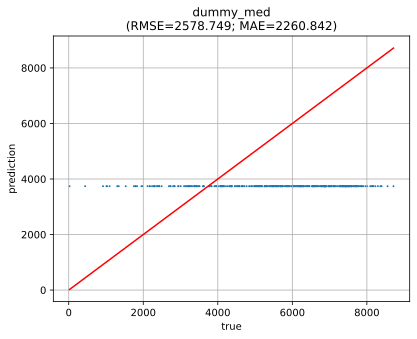

In [19]:
plot_scatter(testY, dummy_med.predict(testX), 'dummy_med')

## Prediction with Linear Regression

First we will look at predicting the count using simple linear regression models.  Use the training data to fit a linear model using Ordinary Least Squares and Ridge Regression.  Use cross-validation on the training set to select the optimal $\alpha$ parameter for ridge regression.

In [20]:
### INSERT YOUR CODE HERE

In [21]:
#线性回归模型
ols= linear_model.LinearRegression()
ols.fit(trainX, trainY)

LinearRegression()

In [22]:
# 岭回归模型
alphas = logspace(-3,6,50)
rr = linear_model.RidgeCV(alphas=alphas, cv=5)
rr.fit(trainX, trainY)

RidgeCV(alphas=array([1.00000000e-03, 1.52641797e-03, 2.32995181e-03, 3.55648031e-03,
       5.42867544e-03, 8.28642773e-03, 1.26485522e-02, 1.93069773e-02,
       2.94705170e-02, 4.49843267e-02, 6.86648845e-02, 1.04811313e-01,
       1.59985872e-01, 2.44205309e-01, 3.72759372e-01, 5.68986603e-01,
       8.68511374e-01, 1.32571137e+00, 2.02358965e+00, 3.08884360e+00,
       4.71486636e+00, 7.19685673e+0...
       2.55954792e+01, 3.90693994e+01, 5.96362332e+01, 9.10298178e+01,
       1.38949549e+02, 2.12095089e+02, 3.23745754e+02, 4.94171336e+02,
       7.54312006e+02, 1.15139540e+03, 1.75751062e+03, 2.68269580e+03,
       4.09491506e+03, 6.25055193e+03, 9.54095476e+03, 1.45634848e+04,
       2.22299648e+04, 3.39322177e+04, 5.17947468e+04, 7.90604321e+04,
       1.20679264e+05, 1.84206997e+05, 2.81176870e+05, 4.29193426e+05,
       6.55128557e+05, 1.00000000e+06]),
        cv=5)

Compare the two models using the RMSE and MAE between the predictions and the true values.  Below is  code that will calculate evaluation for the training and test sets.

In [23]:
# ols is the linear regression model
trainerr['ols'] = eval_predict(trainY, ols.predict(trainX))
testerr['ols']  = eval_predict(testY, ols.predict(testX))
print("OLS: train MSE,MAE =", trainerr['ols'])
print("OLS: test  MSE,MAE =", testerr['ols'])

# rr is the ridge regression model
trainerr['rr'] = eval_predict(trainY, rr.predict(trainX))
testerr['rr']  = eval_predict(testY, rr.predict(testX))
print("RR: train MSE,MAE =", trainerr['rr'])
print("RR: test  MSE,MAE =", testerr['rr'])

OLS: train MSE,MAE = (567.0316388457127, 428.02465753424656)
OLS: test  MSE,MAE = (6614504368571.169, 6614504368571.169)
RR: train MSE,MAE = (549.9374320904268, 407.2983051013793)
RR: test  MSE,MAE = (2305.557150484274, 2128.615790127064)


Which model has better prediction ability on the test set? Why?
- **INSERT YOUR ANSWER HERE**

对离散特征做独热编码时，未处理冗余列或编码后特征与原有特征存在关联，引入了多重共线性；而OLS求解系数依赖特征矩阵相关矩阵（X^T X）可逆，多重共线性会让该矩阵接近不可逆，导致系数极端且不稳定，模型过度拟合训练数据的冗余关联，测试时预测崩溃；但岭回归通过添加 L2 正则化项，将相关矩阵修正为（X^T X + αI），既保证了矩阵可逆性以稳定系数求解，又通过压缩系数绝对值减少对共线性特征的过度依赖，降低过拟合风险，因此在测试集上表现更优。

英文版：
When one-hot encoding discrete features, failure to handle redundant columns or the existence of correlations between encoded features and original features introduces multicollinearity. Ordinary Least Squares (OLS) relies on the invertibility of the feature matrix's correlation matrix (XᵀX) to solve for coefficients. Multicollinearity makes this matrix nearly non-invertible, leading to extreme and unstable coefficients. As a result, the model overfits to the redundant correlations in the training data, causing predictive collapse on the test set. However, Ridge Regression modifies the correlation matrix to (XᵀX + αI) by adding an L2 regularization term. This not only ensures the matrix's invertibility for stable coefficient estimation but also reduces over-reliance on collinear features by shrinking the absolute values of coefficients, thereby lowering the risk of overfitting. Hence, it performs better on the test set.

Finally, we look at the scatter plot for ridge-regression.

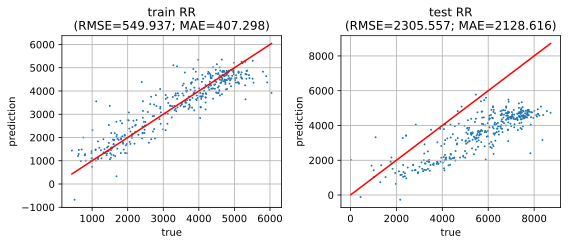

In [24]:
# rr is the ridge regression model
plt.figure(figsize=(8,3.5))
plt.subplot(1,2,1)
plot_scatter(trainY, rr.predict(trainX), "train RR")
plt.subplot(1,2,2)
plot_scatter(testY, rr.predict(testX), "test RR")
plt.tight_layout()

- 每个蓝点代表一个样本的 “真实值（横轴）” 和模型对该样本的 “预测值（纵轴）” 的对应关系。
- 红线：是理想回归线，表示 “预测值完全等于真实值” 的情况（即 prediction=true）。如果模型的预测完全准确，所有蓝点应该都落在这条红线上。

Do you notice anything interesting about the test predictions?  We'll see how to solve this problem later.

- **INSERT YOUR ANSWER HERE**

In the test set, the predictions are more concentrated than the true values, and the predictions are lower than the true values.

# Which features are important?
Next we will investigate which features are the most important for the prediction.  Use LASSO with cross-validation to learn the model.

In [25]:
### INSERT YOUR CODE HERE

In [26]:
# lasso 回归模型
las= linear_model.LassoCV()
las.fit(trainX, trainY)

LassoCV()

In [27]:
print("alpha =", las.alpha_)
print("w =", las.coef_)

alpha = 3.729639752507565
w = [    0.          -169.15011638    62.87031977  3017.21771389
     0.          -734.1885162  -1130.77540609 -1008.43902026
  -232.66547492    36.89731181   208.32423345  -419.4767226
  -253.67744401  -200.79924401     0.           732.6360563
   560.94881986   -17.12331785     0.           417.0832476
   348.61599574    -0.            -0.            -9.57435203
    -0.            23.15635888    -0.            -0.
    37.36474301    82.59011455   372.58080197    -0.
 -1337.87067502]


Examine the LASSO coefficients by sorting them in descending order.

In [28]:
# las is the trained LASSO model
#LASSO 模型训练后得到的特征系数（权重），并按系数绝对值从大到小排序，方便观察哪些特征对模型影响更大
inds = argsort(abs(las.coef_))[::-1]
print("weight : feature description")
for i in inds:
    print("{: .3f} : {}".format(las.coef_[i], featnames[i]))
print("bias = ", las.intercept_)#打印模型的截距项（bias）

weight : feature description
 3017.218 : temp
-1337.871 : weathersit_3
-1130.775 : windspeed
-1008.439 : season_1
-734.189 : hum
 732.636 : mnth_5
 560.949 : mnth_6
-419.477 : mnth_1
 417.083 : mnth_9
 372.581 : weathersit_1
 348.616 : mnth_10
-253.677 : mnth_2
-232.665 : season_2
 208.324 : season_4
-200.799 : mnth_3
-169.150 : holiday
 82.590 : weekday_6
 62.870 : workingday
 37.365 : weekday_5
 36.897 : season_3
 23.156 : weekday_2
-17.123 : mnth_7
-9.574 : weekday_0
-0.000 : weekday_1
 0.000 : mnth_4
-0.000 : weekday_3
-0.000 : weathersit_2
-0.000 : weekday_4
 0.000 : mnth_8
 0.000 : atemp
-0.000 : mnth_11
-0.000 : mnth_12
 0.000 : yr
bias =  2541.3793758494726


_Which features have largest affect on the predicted bike share count, and what is the interpretation解读?_

Note that the features are normalized between 0 and 1 (or are binary values), so the weights corresponding to increase/decrease of bike count.  The bias term corresponds to the typical number of bikes used, which is modified based on the features.
- **INSERT YOUR ANSWER HERE**

Temperature is the most influential factor, likely because the number of bike riders decreases when the temperature is too cold or too hot. Since the temperature has been normalized to the range of 0 to 1, even a small change in its normalized value represents a relatively significant change in actual weather conditions, thus having a comparatively greater impact on the number of bike riders.

Now try feature selection using OMP.  You can try the top 10 features.

In [29]:
### INSERT YOUR CODE HERE

In [30]:
# omp模型
omp = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=10)
omp.fit(trainX, trainY)

OrthogonalMatchingPursuit(n_nonzero_coefs=10)

In [31]:
inds_omp = argsort(abs(omp.coef_))[::-1]
print("weight : feature description")
for i in inds_omp:
    print("{: .3f} : {}".format(omp.coef_[i], featnames[i]))
print("bias = ", omp.intercept_)#打印模型的截距项（bias）

weight : feature description
 3214.272 : temp
-1544.453 : weathersit_3
 855.331 : mnth_5
-780.259 : season_1
 739.020 : season_4
 718.328 : mnth_6
 492.108 : weathersit_1
 412.039 : mnth_9
 372.515 : season_3
-212.365 : mnth_1
 0.000 : weekday_3
 0.000 : mnth_2
 0.000 : holiday
 0.000 : workingday
 0.000 : atemp
 0.000 : hum
 0.000 : windspeed
 0.000 : weekday_6
 0.000 : season_2
 0.000 : weekday_5
 0.000 : mnth_3
 0.000 : weekday_2
 0.000 : mnth_4
 0.000 : weekday_4
 0.000 : weathersit_2
 0.000 : mnth_7
 0.000 : mnth_8
 0.000 : mnth_10
 0.000 : mnth_11
 0.000 : mnth_12
 0.000 : weekday_0
 0.000 : weekday_1
 0.000 : yr
bias =  1368.9986544538033


Do you get similar selected features? Why or why not?
- **INSERT YOUR ANSWER HERE**

Selected features aren't identical. Core ones like temperature overlap, but some differ due to method principles and data.

# Non-linear Regression
Now use non-linear regression to try to improve the prediction accuracy.  Use cross-validation on the training set to select the parameters. 

In [32]:
### INSERT YOUR CODE HERE

In [33]:
import time

In [53]:
# 非线性回归模型之核贝叶斯回归
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
start_time = time.time()
param_prid={'alpha':[1e-3,1e-2,1e-1,1,10],'kernel':['rbf','poly'],'gamma':[0.1,1,10]}
kr=KernelRidge()
grid_search=GridSearchCV(kr,param_prid,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
grid_search.fit(trainX,trainY)
train_time=time.time()-start_time

best_kr=grid_search.best_estimator_

pred_start=time.time()
test_pred=best_kr.predict(testX)
pred_time=time.time()-pred_start

print("best parameters:",grid_search.best_params_)
print(f"test MSE: {mean_squared_error(testY, test_pred):.2f}")
print("training time:",train_time)
print("prediction time:",pred_time)

best parameters: {'alpha': 1, 'gamma': 0.1, 'kernel': 'poly'}
test MSE: 5502996.75
training time: 1.361058235168457
prediction time: 0.00901031494140625


Make a scatter plot of the best regressor. Call it `bestr`.

In [35]:
# SVR
from sklearn.svm import SVR
start_time = time.time()
param_prid={'C':[0.1,1,10],'kernel':['rbf','poly'],'gamma':['scale'],'epsilon':[0.1,0.5]}
svr=SVR()
grid_search=GridSearchCV(svr,param_prid,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
grid_search.fit(trainX,trainY)
train_time=time.time()-start_time   
best_svr=grid_search.best_estimator_
pred_start=time.time()
test_pred=best_svr.predict(testX)   
pred_time=time.time()-pred_start
print("best parameters:",grid_search.best_params_)
print(f"test MSE: {mean_squared_error(testY, test_pred):.2f}")
print("training time:",train_time)
print("prediction time:",pred_time)

best parameters: {'C': 10, 'epsilon': 0.5, 'gamma': 'scale', 'kernel': 'poly'}
test MSE: 6340175.00
training time: 0.17435169219970703
prediction time: 0.0


In [36]:
#决策树
from sklearn.tree import DecisionTreeRegressor
start_time = time.time()
param_prid={'max_depth':[3,5,10,15,20],'min_samples_split':[2,5,10],'min_samples_leaf':[1,2,4]}
dtr=DecisionTreeRegressor(random_state=0)   
grid_search=GridSearchCV(dtr,param_prid,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
grid_search.fit(trainX,trainY)
train_time=time.time()-start_time   
best_dtr=grid_search.best_estimator_
pred_start=time.time()
test_pred=best_dtr.predict(testX)
pred_time=time.time()-pred_start
print("best parameters:",grid_search.best_params_)  
print(f"test MSE: {mean_squared_error(testY, test_pred):.2f}")
print("training time:",train_time)
print("prediction time:",pred_time)


best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
test MSE: 5251195.37
training time: 0.41436266899108887
prediction time: 0.0


In [37]:
#随机森林
from sklearn.ensemble import RandomForestRegressor
start_time = time.time()
rfr=RandomForestRegressor(random_state=0)
param_prid={'n_estimators':[50,100,200],'max_depth':[10,20,30],'min_samples_split':[2,5,10],'min_samples_leaf':[1,2,4]}
grid_search=GridSearchCV(rfr,param_prid,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
grid_search.fit(trainX,trainY)
train_time=time.time()-start_time
best_rfr=grid_search.best_estimator_
pred_start=time.time()
test_pred=best_rfr.predict(testX)
pred_time=time.time()-pred_start
print("best parameters:",grid_search.best_params_)
print(f"test MSE: {mean_squared_error(testY, test_pred):.2f}")
print("training time:",train_time)
print("prediction time:",pred_time)


best parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
test MSE: 4875492.90
training time: 17.819891452789307
prediction time: 0.020666122436523438


In [38]:
#xgboost 回归
import xgboost as xgb
start_time = time.time()
param_prid={'n_estimators':[50,100,200],'max_depth':[3,5,7],'alpha':[0,10,50]}
xgb_reg=xgb.XGBRegressor(objective='reg:squarederror',random_state=0)
grid_search=GridSearchCV(xgb_reg,param_prid,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
grid_search.fit(trainX,trainY)
train_time=time.time()-start_time
best_xgb=grid_search.best_estimator_
pred_start=time.time()
test_pred=best_xgb.predict(testX)
pred_time=time.time()-pred_start
print("best parameters:",grid_search.best_params_)
print(f"test MSE: {mean_squared_error(testY, test_pred):.2f}")
print("training time:",train_time)
print("prediction time:",pred_time)



best parameters: {'alpha': 0, 'max_depth': 3, 'n_estimators': 50}
test MSE: 4758682.76
training time: 2.64078426361084
prediction time: 0.0036759376525878906


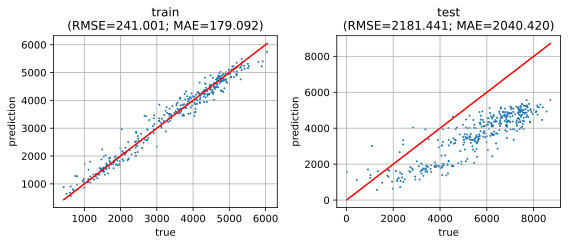

In [39]:
# scatter plot of the best regressor (bestr)
bestr = best_xgb
plt.figure(figsize=(8,3.5))
plt.subplot(1,2,1)
plot_scatter(trainY, bestr.predict(trainX), "train")
plt.subplot(1,2,2)
plot_scatter(testY, bestr.predict(testX), "test")
plt.tight_layout()

_Which regression method performs the best? Why do you think so?_
- **INSERT YOUR ANSWER HERE**

Among all the regression methods tested, XGBoost performs the best, primarily because it achieves the lowest Mean Squared Error (MSE) on the test set.

# Test set bias

In your scatter plot above, you may have noticed that the regressor is almost always under-predicting the count (the points are usually below the red line). This suggests that there is some bias in the test set.

Let's look at the plot of the count over time.  The left side is the training data (1st year), and the right side is the testing data (2nd year)

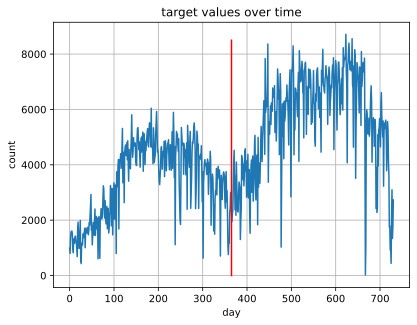

In [40]:
plt.plot(dataY)
plt.plot([365,365], [0,8500], 'r')
plt.grid(True)
plt.xlabel('day')
plt.ylabel('count')
plt.title('target values over time');

Interestingly, it looks like bike sharing became more popular in the 2nd year, so the overall counts are higher (but the seasonal trend looks the same).

Let's assume that we noticed this upward trend in the first 3 months of the year, and collected the data for training.  We will then use the remaining part of the 2nd year for testing.

In [41]:
for i in range(len(featnames)):
    print(i, featnames[i]),

0 yr
1 holiday
2 workingday
3 temp
4 atemp
5 hum
6 windspeed
7 season_1
8 season_2
9 season_3
10 season_4
11 mnth_1
12 mnth_2
13 mnth_3
14 mnth_4
15 mnth_5
16 mnth_6
17 mnth_7
18 mnth_8
19 mnth_9
20 mnth_10
21 mnth_11
22 mnth_12
23 weekday_0
24 weekday_1
25 weekday_2
26 weekday_3
27 weekday_4
28 weekday_5
29 weekday_6
30 weathersit_1
31 weathersit_2
32 weathersit_3


In [42]:
# 打印特征名称列表中索引11、12、13对应的特征名，确认这三列分别对应1月、2月、3月（因数据中月份特征为独热编码）
print(featnames[11], featnames[12], featnames[13])

# 筛选出测试集（即第二年数据）中属于1月、2月或3月的样本索引
# testX[:,11]：取第二年数据中第11列（1月的独热编码特征），值为1表示该样本属于1月
# ravel()：将数组展平为一维（确保维度统一，避免判断时出错）
# 三个条件用+连接（等价于逻辑或），最终inds是布尔数组：True表示样本属于第二年的1-3月
inds = (testX[:,11].ravel()==1) + (testX[:,12].ravel()==1) + (testX[:,13].ravel()==1)

# 从第二年数据中提取1-3月的样本作为新训练集
trainX2 = testX[inds]  # 新训练集的特征（第二年1-3月）
trainY2  = testY[inds]  # 新训练集的标签（对应第二年1-3月的骑行量）

# 从第二年数据中提取4-12月的样本作为新测试集
# logical_not(inds)：对inds取反，True表示样本不属于1-3月（即属于第二年4-12月）
testX2  = testX[logical_not(inds)]  # 新测试集的特征（第二年4-12月）
testY2   = testY[logical_not(inds)]  # 新测试集的标签（对应第二年4-12月的骑行量）

# 打印新训练集和新测试集的形状，验证数据划分是否符合预期（样本数×特征数）
print(trainX2.shape)
print(testX2.shape)

mnth_1 mnth_2 mnth_3
(91, 33)
(275, 33)


There are several approaches for using the new data:
1. use the new data to train the regressor, and ignore the old data.
2. append the new data with the old data and train a regressor.  Note that we kept the "year" feature, so the regressor can distinguish the new and old training data.
3. use the new data to train a regressor on the residual error of the old regressor.  The residual error is the difference between the predicted count and true count on the new training data.

Using **one selected** regression method, try each of the approaches above to use the new data. You should compare the 3 approaches with the regressor trained on the original data and tested on the new test set (`testY2`).

In [43]:
# append new data with old data
trainX2_append = concatenate((trainX, trainX2), axis=0)
trainY2_append = concatenate((trainY, trainY2), axis=0)
print(trainX2_append.shape)
print(trainY2_append.shape)

(456, 33)
(456,)


In [44]:
### INSERT YOUR CODE HERE

In [45]:
# 超参数，模型选择
param_prid={'n_estimators':[50,100,200],'max_depth':[3,5,7],'alpha':[0,10,50]}
xgb_reg=xgb.XGBRegressor(objective='reg:squarederror',random_state=0)


In [46]:
#旧数据
grid_search=GridSearchCV(xgb_reg,param_prid,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
grid_search.fit(trainX,trainY)
best_xgb=grid_search.best_estimator_
test_pred=best_xgb.predict(testX2)
print(f"test MSE: {mean_squared_error(testY2, test_pred):.2f}")

test MSE: 4990696.12


In [ ]:
# 新数据
grid_search1=GridSearchCV(xgb_reg,param_prid,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
grid_search1.fit(trainX2, trainY2)
best_model1 = grid_search1.best_estimator_

# 在testY2上
pred1 = best_model1.predict(testX2)
print(f"MSE:{mean_squared_error(testY2, pred1):.2f}")

MSE:1325125.01


In [ ]:
# 新旧一起
grid_search2=GridSearchCV(xgb_reg,param_prid,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
grid_search2.fit(trainX2_append, trainY2_append)
best_model2 = grid_search2.best_estimator_

# 在testY2上
pred2 = best_model2.predict(testX2)
print(f"MSE:{mean_squared_error(testY2, pred2):.2f}")

MSE:869547.83


In [ ]:
#残差训练
residuals = trainY2 - best_xgb.predict(trainX2)  # 残差 = 真实值 - 基础模型预测值
grid_search3=GridSearchCV(xgb_reg,param_prid,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
grid_search3.fit(trainX2, residuals)
residual_model = grid_search3.best_estimator_

# 在testY2上
base_pred=best_xgb.predict(testX2)
final_pred = base_pred + residual_model.predict(testX2)
print(f"MSE:{mean_squared_error(testY2, final_pred):.2f}")

MSE:1253936.86


_Which approach for using the new data is better? Explain why you think the other approaches don't work well._
- **INSERT YOUR ANSWER HERE**

The approach of combining old and new data for training is better. The method that only uses new data for training abandons the historical patterns (such as seasonal rules, etc.) contained in the old data, making it difficult to fully learn the complete logic of changes in bike - sharing counts. Although residual training is optimized based on the old model, it is limited by the initial deviation of the old model, and the improvement in fitting new data is restricted. However, combining old and new data allows the model to learn both historical rules and new trends (such as the increase in volume due to bike - sharing being more popular in the second year) at the same time. Moreover, the retained "year" feature can assist the model in distinguishing data from different periods, so that it can capture the changes in bike - sharing counts more comprehensively and accurately, and the prediction effect is better.